# LifCare Case Study Presentation

In [2]:
library(sqldf)
library(lubridate)
library(ggplot2)

In [3]:
order1<-read.csv("order.csv")
customer<-read.csv("customer.csv")

In [6]:
#Data preparation
order1$ORDER_TOTAL<-as.numeric(as.character(order1$ORDER_TOTAL))
order1$ORDER_DATE<-as.Date(order1$ORDER_DATE, "%m / %d / %Y")

## Q. 1 Are there any data anomaly in the order and customer data. If yes, please list them down

In [8]:
#Outlier in customer table
head(sqldf("select CONTACT_NUMBER from customer order by CONTACT_NUMBER desc"),10)
sqldf("select * from customer where CONTACT_NUMBER=99387789901")
print("Customer id 12 is an outlier")

CONTACT_NUMBER
99387789901
9999671883
9999671883
9999608892
9999608892
9999596298
9999529732
9999510118
9999510118
9999510118


CUSTOMER_ID,CUSTOMER_KEY,CONTACT_NUMBER,Referred.Other.customers
12,C100008,99387789901,Y


[1] "Customer id 12 is an outlier"


In [10]:
#Extreme value in  order table
head(sqldf("select ORDER_TOTAL from order1 order by ORDER_TOTAL desc"),10)
sqldf("select * from order1 where ORDER_TOTAL in (64130.38,51637.50)")
print("The above 2 ORDER_TOTAL are extreme values")

ORDER_TOTAL
64130.38
51637.50
25389.50
25075.00
25075.00
20967.00
20034.50
19890.14
18436.50
18436.50


ORDER_NUMBER,CUSTOMER_KEY,ORDER_TOTAL,DISCOUNT,ORDER_DATE,ORDER_STATUS,DELIVERY_STATUS
O101626,C100213,64130.38,0,2016-06-06,Delivered,LATE
O119258,C15598,51637.50,0,2016-06-06,Delivered,ON-TIME


[1] "The above 2 ORDER_TOTAL are extreme values"


## Q. 2 Total orders placed by top 20 customers (based on order value)

In [12]:
result1<-sqldf("SELECT CUSTOMER_KEY, sum(ORDER_TOTAL) FROM order1 GROUP BY CUSTOMER_KEY ORDER BY sum(ORDER_TOTAL) DESC LIMIT 20;")
result2<-sqldf("sELECT COUNT(*) as Total_orders_placed FROM order1 WHERE CUSTOMER_KEY IN (SELECT CUSTOMER_KEY FROM result1);")
result2

Total_orders_placed
299


## Q. 3 Month-wise split of total order value of the top 50 customers (The top 50 customers need to identified based on their total order value)

In [42]:
order1$Month<-months(order1$ORDER_DATE)
order1$Monthno<-month(order1$ORDER_DATE)

result1<-sqldf("SELECT CUSTOMER_KEY, SUM(ORDER_TOTAL) FROM order1 GROUP BY CUSTOMER_KEY ORDER BY SUM(ORDER_TOTAL) DESC LIMIT 50;")
result2<-sqldf("SELECT Month, Monthno, SUM(ORDER_TOTAL) as ORDER_TOTAL FROM order1 WHERE CUSTOMER_KEY IN (SELECT CUSTOMER_KEY FROM result1) GROUP BY Month order by Monthno")

result2$Month<-factor(result2$Month, levels=result2[order(result2$Monthno),1])

result2[,-2]

Month,ORDER_TOTAL
January,40712.79
February,107039.81
March,271574.64
April,206963.96
May,257017.85
June,479944.09
July,205443.27
November,20974.73
December,67163.48


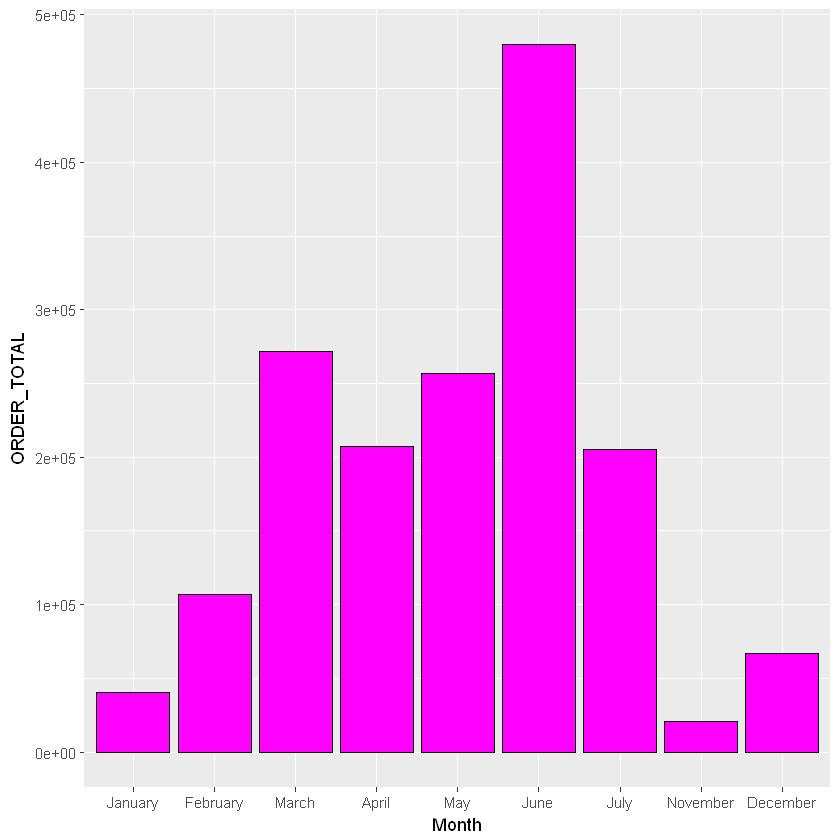

In [14]:
p<-ggplot(data = result2,aes(x=Month, y=ORDER_TOTAL))
p+geom_bar(stat="identity",colour="black", fill = "magenta")

## Q. 4 Plot of month-on-month growth in order count and revenue (from Nov’15 to July’16)

In [38]:
order1$Year<-year(order1$ORDER_DATE)
order1$Month<-months(order1$ORDER_DATE)
order1$Month<-as.factor(order1$Month)
order1$Month<-factor(order1$Month,levels = unique(order1[order(order1$Monthno),8]))

In [39]:
order2<-order1
order2<-order2[order(order2$Year,order2$Monthno),]
order2$MY<-paste(order2$Month,order2$Year)
order2$MY<-as.factor(order2$MY)
order2$MY<-factor(order2$MY,levels=rev(unique(order2$MY)))

MY,COUNT
November 2015,751
December 2015,1105
January 2016,1460
February 2016,2410
March 2016,2530
April 2016,3624
May 2016,4710
June 2016,7785
July 2016,5241


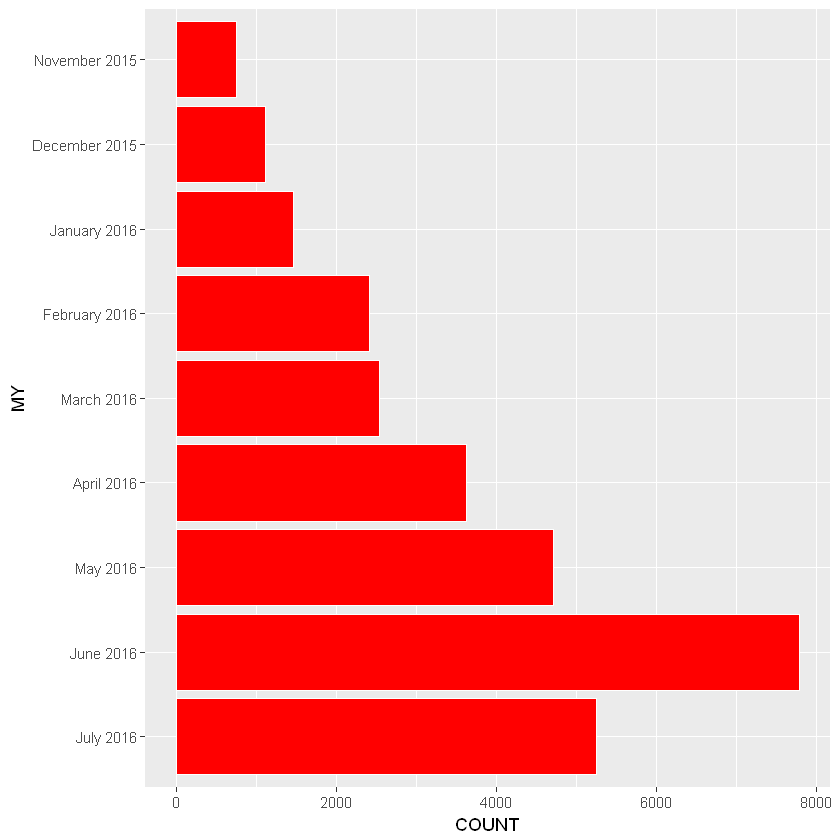

In [40]:
result1<-sqldf("select MY, count(*) as COUNT from order2 group by MY order by Year, Monthno")
result1
p<-ggplot(data = result1,aes(x=MY,y=COUNT))
p+geom_bar(stat="identity", colour="white", fill="red")+coord_flip()

## Q. 5  Month-wise split of new and repeat customers

In [19]:
order2<-order1
order2<-order2[order(order2$Monthno),]

#### For Repeat Customer

In [34]:
result1<-sqldf("select CUSTOMER_KEY from order1 group by CUSTOMER_KEY having count(CUSTOMER_KEY)>1")
result2<-sqldf("select Month, count(CUSTOMER_KEY) as COUNT from order1 where CUSTOMER_KEY in result1 group by Month order by Monthno")
result2$Month<-factor(result2$Month,levels=(unique(result2$Month)))
result2

Month,COUNT
January,1284
February,2099
March,2206
April,2925
May,3963
June,6076
July,3792
November,736
December,1044


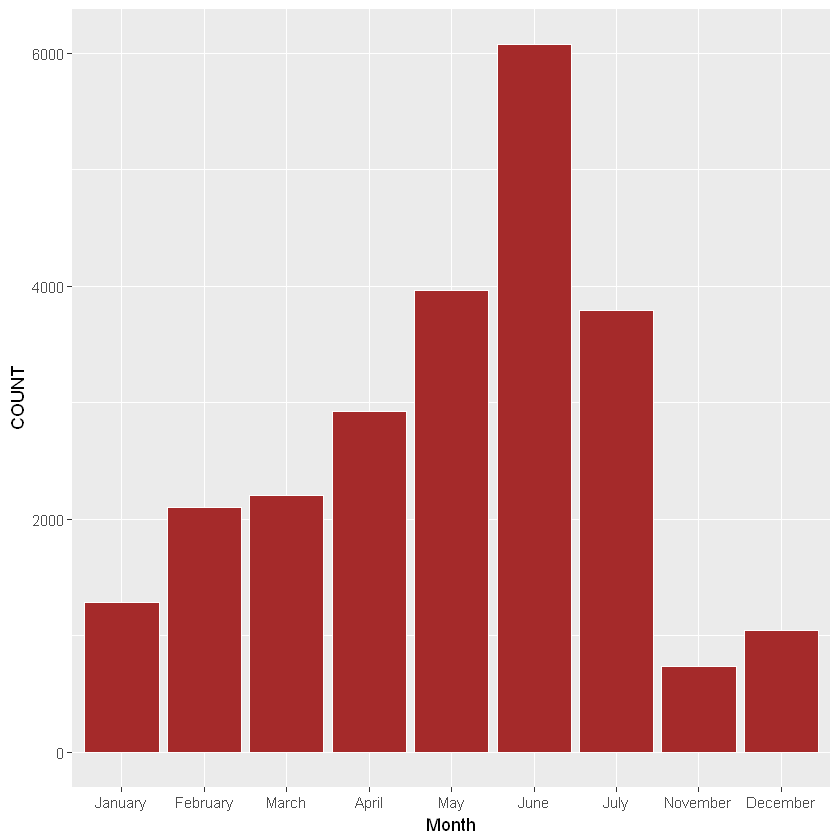

In [25]:
p<-ggplot(data = result2,aes(x=Month,y=COUNT))
p+geom_bar(stat="identity", colour="white", fill="brown")

### For New customers

In [33]:
result1<-sqldf("select CUSTOMER_KEY from order1 group by CUSTOMER_KEY having count(CUSTOMER_KEY)=1")
result2<-sqldf("select Month, count(CUSTOMER_KEY) as COUNT from order1 where CUSTOMER_KEY in result1 group by Month order by Monthno")
result2$Month<-factor(result2$Month,levels=(unique(result2$Month)))
result2

Month,COUNT
January,176
February,311
March,324
April,699
May,747
June,1709
July,1449
November,15
December,61


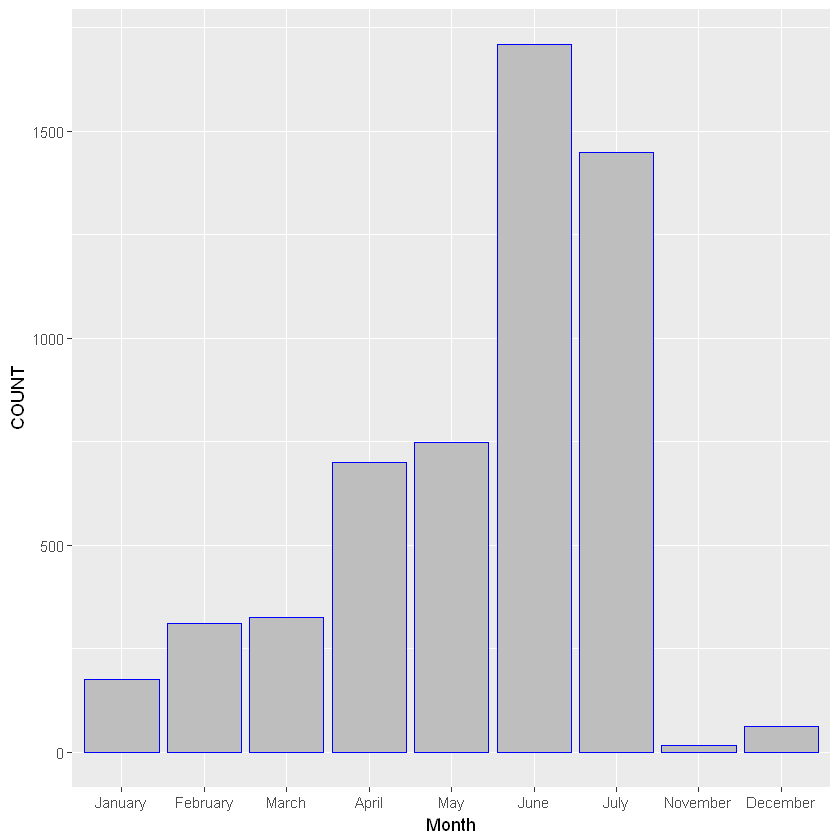

In [27]:
p<-ggplot(data = result2,aes(x=Month,y=COUNT))
p+geom_bar(stat="identity", colour="blue", fill="grey")

## Q. 6 Month-wise split of number of new and repeat orders placed

### Repeat orders

In [29]:
result1<-sqldf("select ORDER_NUMBER from order1 group by ORDER_NUMBER having count(ORDER_NUMBER)>1")
result2<-sqldf("select Month, count(ORDER_NUMBER) as COUNT from order1 where ORDER_NUMBER in result1 group by Month order by Monthno")
result2
print("No Repeat Orders")

Month,COUNT


[1] "No Repeat Orders"


### New orders

In [32]:
result1<-sqldf("select ORDER_NUMBER from order1 group by ORDER_NUMBER having count(ORDER_NUMBER)=1")
result2<-sqldf("select Month, count(ORDER_NUMBER) as COUNT from order1 where ORDER_NUMBER in result1 group by Month order by Monthno")
result2$Month<-factor(result2$Month,levels=(unique(result2$Month)))
result2

Month,COUNT
January,1460
February,2410
March,2530
April,3624
May,4710
June,7785
July,5241
November,751
December,1105


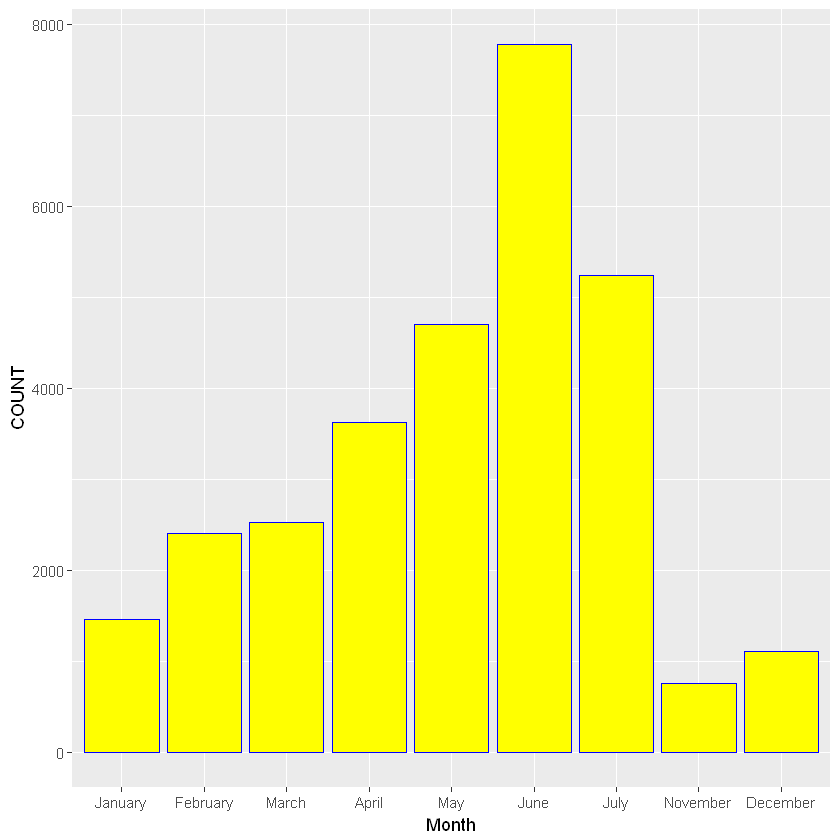

In [31]:
p<-ggplot(data = result2,aes(x=Month,y=COUNT))
p+geom_bar(stat="identity", colour="blue", fill="yellow")

## Q. 7 Cohort wise retention of customers on volume basis (i.e. of total customers acquired in Jan'16, how many transacted over the months in Feb, March, April,..., Nov, Dec'16)

In [44]:
order2<-order1
order2<-order2[which(order2$Month==c('November','December','January')),]
beforejan<-order2[-which(order2$Month==c('November','December')),"CUSTOMER_KEY"]
beforejan<-as.data.frame(unique(beforejan))

Warning message in order2$Month == c("November", "December"):
"longer object length is not a multiple of shorter object length"

In [45]:
order2<-order1
order2<-order2[which(order2$Year==2016),]
order2<-order2[-which(order2$Month=="January"),]

In [49]:
result1<-sqldf("select Month, Monthno,count(CUSTOMER_KEY) as RETAINED_COUNT from order2 where CUSTOMER_KEY in beforejan group by Month order by Monthno")
result1$Month<-factor(result1$Month, levels = result1[order(result1$Monthno),1])
result1[,-2]

Month,RETAINED_COUNT
February,508
March,121
April,130
May,169
June,307
July,205


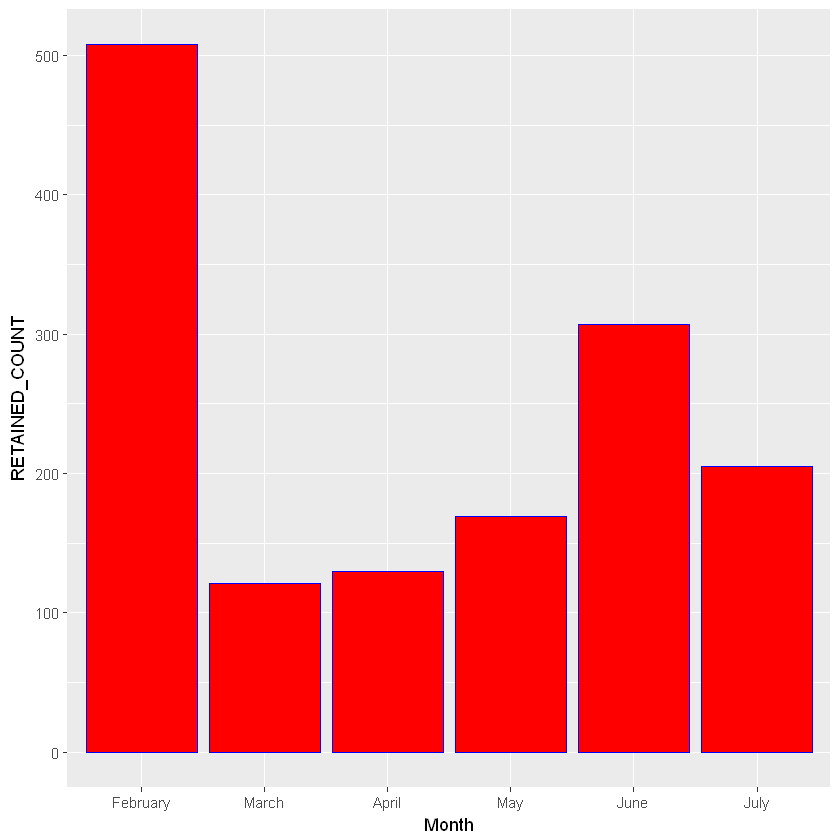

In [50]:
p<-ggplot(data = result1,aes(x=Month,y=RETAINED_COUNT))
p+geom_bar(stat="identity", colour="blue", fill="red")

## Q. 8 Split of order status by month

In [51]:
r1<-sqldf("select Month,count(ORDER_STATUS) as DELIVERED from order1 where ORDER_STATUS='Delivered' group by Month")
r2<-sqldf("select Month,count(ORDER_STATUS) as CANCELLED from order1 where ORDER_STATUS='Cancelled' group by Month")
r3<-sqldf("select Month,count(ORDER_STATUS) as CREATED from order1 where ORDER_STATUS='Created' group by Month")
r4<-sqldf("select Month,count(ORDER_STATUS) as PACKAGED from order1 where ORDER_STATUS='Packaged' group by Month")

In [52]:
result1<-merge(r1,r2,by="Month",all.x = TRUE)
result1<-merge(result1,r3,by="Month",all.x = TRUE)
result1<-merge(result1,r4,by="Month",all.x = TRUE)

In [54]:
for(i in 2:5){
  result1[which(is.na(result1[,i])),i]<-0
}
result1

Month,DELIVERED,CANCELLED,CREATED,PACKAGED
April,3620,4,0,0
December,1098,7,0,0
February,2348,62,0,0
January,1460,0,0,0
July,5214,24,1,2
June,7758,27,0,0
March,2521,9,0,0
May,4691,19,0,0
November,742,9,0,0


## Q. 9 Identify the dropped customers (that haven't ordered in the last 60 days) and segment them in categories so that they can be targeted differently. 

In [55]:
order2<-order1
order2$DAY<-day(order2$ORDER_DATE)
order2<-order2[order(-order2$Year,-order2$Monthno,-order2$DAY),]

In [56]:
last60<-head(unique(order2$ORDER_DATE),60)
cust60<-order2[which(order2$ORDER_DATE==last60),2]

Warning message in `==.default`(order2$ORDER_DATE, last60):
"longer object length is not a multiple of shorter object length"

In [57]:
custnot60<-order2$CUSTOMER_KEY[-which(order2$CUSTOMER_KEY==cust60)]
custnot60<-data.frame(custnot60)
names(custnot60)[1]<-"CUSTOMER_KEY"

Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"Warning message in `==.default`(order2$CUSTOMER_KEY, cust60):
"longer object length is not a multiple of shorter object length"

In [58]:
once<-sqldf("select CUSTOMER_KEY from custnot60 group by CUSTOMER_KEY having count(CUSTOMER_KEY)=1")
multiple<-sqldf("select CUSTOMER_KEY from custnot60 group by CUSTOMER_KEY having count(CUSTOMER_KEY)>1")

In [60]:
print("First 10 customer keys that do not appear in last 60 days. The keys in the first table occurs once and keys in the second table occurs multiple times")
head(once,10)
head(multiple,10)

[1] "First 10 customer keys that do not appear in last 60 days. The keys in the first table occurs once and keys in the second table occurs multiple times"


CUSTOMER_KEY
C100001
C100003
C100004
C100006
C100007
C100008
C100012
C100019
C100023
C100028


CUSTOMER_KEY
C100000
C100002
C100005
C100009
C100010
C100011
C100013
C100014
C100015
C100016


## Q. 10 Any other useful insights -  Top 10 customers based on number of orders placed

In [61]:
result1<-sqldf("select CUSTOMER_KEY, count(CUSTOMER_KEY) as COUNT from order1 group by CUSTOMER_KEY having count(CUSTOMER_KEY)>1 order by COUNT desc")
head(result1,10)

CUSTOMER_KEY,COUNT
C10373,63
C10115,40
C10041,34
C10465,33
C10348,32
C10146,31
C10201,30
C10067,29
C100755,27
C10217,26
